In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pinocchio as pin
from src.embedding import Embedding
from src.forward_kinematics import ForwardKinematic
from src.dynamical_system import DynamicalSystem
from utils.franka_parameters import joint_limits

In [2]:
fk = ForwardKinematic(urdf_file='franka_description/urdf/panda_no_gripper.urdf')
config_dim = fk.model.nq

K = 1 * np.eye(config_dim)
D = 1.5*np.eye(config_dim)

lower_bound = np.array([limit['lower'] for limit in joint_limits])
upper_bound = np.array([limit['upper'] for limit in joint_limits])
# config_attractor = pin.randomConfiguration(fk.model, lower_bound, upper_bound)
config_attractor = np.array([-1.98940735, -0.34923044, -2.14521628, -2.74515598,  2.89106801, 0.80532853,  0.07493805])
print(f'attractor : {config_attractor}')

x = np.array([[-0.2], [-0.1], [0.6]])[np.newaxis, :]

e = Embedding(dimension=config_dim, x=x.repeat(1, 0), fk=fk, limits=joint_limits)

ds = DynamicalSystem(stiffness=K, dissipation=D, attractor=config_attractor, embedding=e, dt=0.01)

attractor : [-1.98940735 -0.34923044 -2.14521628 -2.74515598  2.89106801  0.80532853
  0.07493805]


In [3]:
# config_start = pin.neutral(fk.model)
# config_start = pin.randomConfiguration(fk.model, lower_bound, upper_bound)
config_start = np.array([0., 0., 0., -1.5, 0., 1.5, 0.])
initial_speed = (config_attractor - config_start) * 0.1
# initial_speed = np.zeros_like(config_start)
q = config_start
dq = initial_speed
positions = []
frequencies = []
for i in range(0,1000):
    start1 = time.time()
    q, dq = ds(q, dq)
    positions.append(q)
    frequencies.append(1/(time.time() - start1))
print(f'average execution frequency : {sum(frequencies)/len(frequencies):.4f} Hz')
ps= np.stack(positions)

/home/baudouin/Programs/GDSOA/src/embedding.py:35: RuntimeWarning: overflow encountered in power
  upper_bound = 10 / (1 + np.power(np.exp(10*(self.limits[1] - q)), 4))


average execution frequency : 231.0397 Hz


# Visualization

In [4]:
def plot_3d_ellipsoid_from_covariance(covariance_matrix, center=[0, 0, 0], ax=None, color='blue'):
    # From chatgpt
    """
    Plot a 3D ellipsoid from a covariance matrix.

    Args:
    covariance_matrix (array-like): Covariance matrix of shape (3, 3).
    center (array-like, optional): Center of the ellipsoid. Default is [0, 0, 0].
    ax (matplotlib.axes.Axes, optional): Axes to plot on. If not provided, a new figure will be created.

    Returns:
    matplotlib.axes.Axes: Axes object containing the plot.
    """
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    # Eigenvalue decomposition of covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Sort eigenvalues and corresponding eigenvectors
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Radii of the ellipsoid (square root of eigenvalues)
    radii = np.sqrt(eigenvalues)

    # Create sphere mesh
    u = np.linspace(0, 2 * np.pi, 10)
    v = np.linspace(0, np.pi, 10)
    x = radii[0] * np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones(np.size(u)), np.cos(v))

    # Apply rotation
    points = np.array([x.flatten(), y.flatten(), z.flatten()]).T
    rotated_points = np.dot(points, eigenvectors.T)
    x = np.reshape(rotated_points[:, 0], x.shape)
    y = np.reshape(rotated_points[:, 1], y.shape)
    z = np.reshape(rotated_points[:, 2], z.shape)

    # Plot ellipsoid
    ax.plot_surface(x + center[0], y + center[1], z + center[2], color=color, alpha=0.5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    return ax

def visualize_robot(fk: ForwardKinematic, obstacle: np.ndarray = None, color='blue'):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(*(fk.mus[:, i] for i in range(3)), c=color)
    for i in range(fk.sigmas.shape[0]):
        plot_3d_ellipsoid_from_covariance(fk.sigmas[i], center=fk.mus[i], ax=ax, color=color)
    if obstacle is not None:
        ax.scatter(x[:, 0], x[:, 1], x[:, 2], c='black', s=100)
    ax.set_xlim([-2.1, 2.1])
    ax.set_ylim([-0.1, 2.1])
    ax.set_zlim([-0.1, 1.3])
    ax.axis('equal')
    return ax

In [5]:
from itertools import combinations

def plot_coupled_embeddings(coordinates, attractor, streamlines, embedding, start):
    couples = list(combinations(np.linspace(0, coordinates.shape[1]-1, coordinates.shape[1]), r=2))
    fig, axs = plt.subplots(coordinates.shape[1], int(len(couples)/coordinates.shape[1]))
    fig.set_size_inches(15, 20)
    row = -1
    for b, couple in enumerate(couples):
        if axs.ndim == 1:
            ax = axs[b]
        else:
            if b%axs.shape[1] == 0: row +=1
            ax = axs[row, b%axs.shape[1]]
        angle1 = min(int(couple[0]), int(couple[1]))
        angle2 = max(int(couple[0]), int(couple[1]))
        x = np.unique(embedding[:, angle1])
        y = np.unique(embedding[:, angle2])
        f = embedding[:, -1].reshape(tuple(x.shape[0] for _ in range(embedding.shape[1]-1)))
        dims_to_sum = tuple(map(lambda tup: tup[0], filter(lambda tup: tup[1], [(i, i not in (angle1, angle2)) for i in range(coordinates.shape[1])])))
        z = f.sum(dims_to_sum) 
        if angle1 == 0:
            ax.contourf(x, y, z, antialiased=False, alpha=0.35, cmap=cm.coolwarm, levels=10)
        else:
            ax.contourf(x, y, z.T, antialiased=False, alpha=0.35, cmap=cm.coolwarm, levels=10)
        if attractor is not None:
            ax.scatter(attractor[angle1], attractor[angle2], marker='*', label='target', c='navy', s=40)
        if start is not None:
            ax.scatter(start[angle1], start[angle2], marker='*', label='start', c='gold', s=40)
        if streamlines is not None:
            ax.scatter(streamlines[:, angle1], streamlines[:, angle2], label='path', c='black', s=1)
        ax.set_xlabel(f'q{angle1+1}')
        ax.set_ylabel(f'q{angle2+1}')
        ax.set_xlim([-np.pi, np.pi])
        ax.set_ylim([-np.pi, np.pi])
        ax.legend(loc='upper right')
    fig.tight_layout()
    return ax


In [6]:
def generate_grid_coordinates(joint_limits, resolution: int=5):
    qs = tuple(np.linspace(-np.pi, np.pi, resolution) for limit in joint_limits)
    # qs = tuple(np.linspace(limit['lower'], limit['upper'], resolution) for limit in joint_limits)
    grids = np.meshgrid(*qs)
    return np.column_stack(tuple(g.ravel() for g in grids))

In [7]:
from utils.franka_parameters import joint_limits

grid = generate_grid_coordinates(joint_limits=joint_limits, resolution=5)
print(grid.shape)

(78125, 7)


In [8]:
a = np.zeros((grid.shape[0], grid.shape[1]+1))
freq = []
for i, q in enumerate(grid):
    start = time.time()
    p = e.value_only(q).sum()
    a[i] = np.array([*q, p])
    freq.append(1/(time.time() - start))
print(f'average freq : {sum(freq)/len(freq)}')

average freq : 12524.793088570297


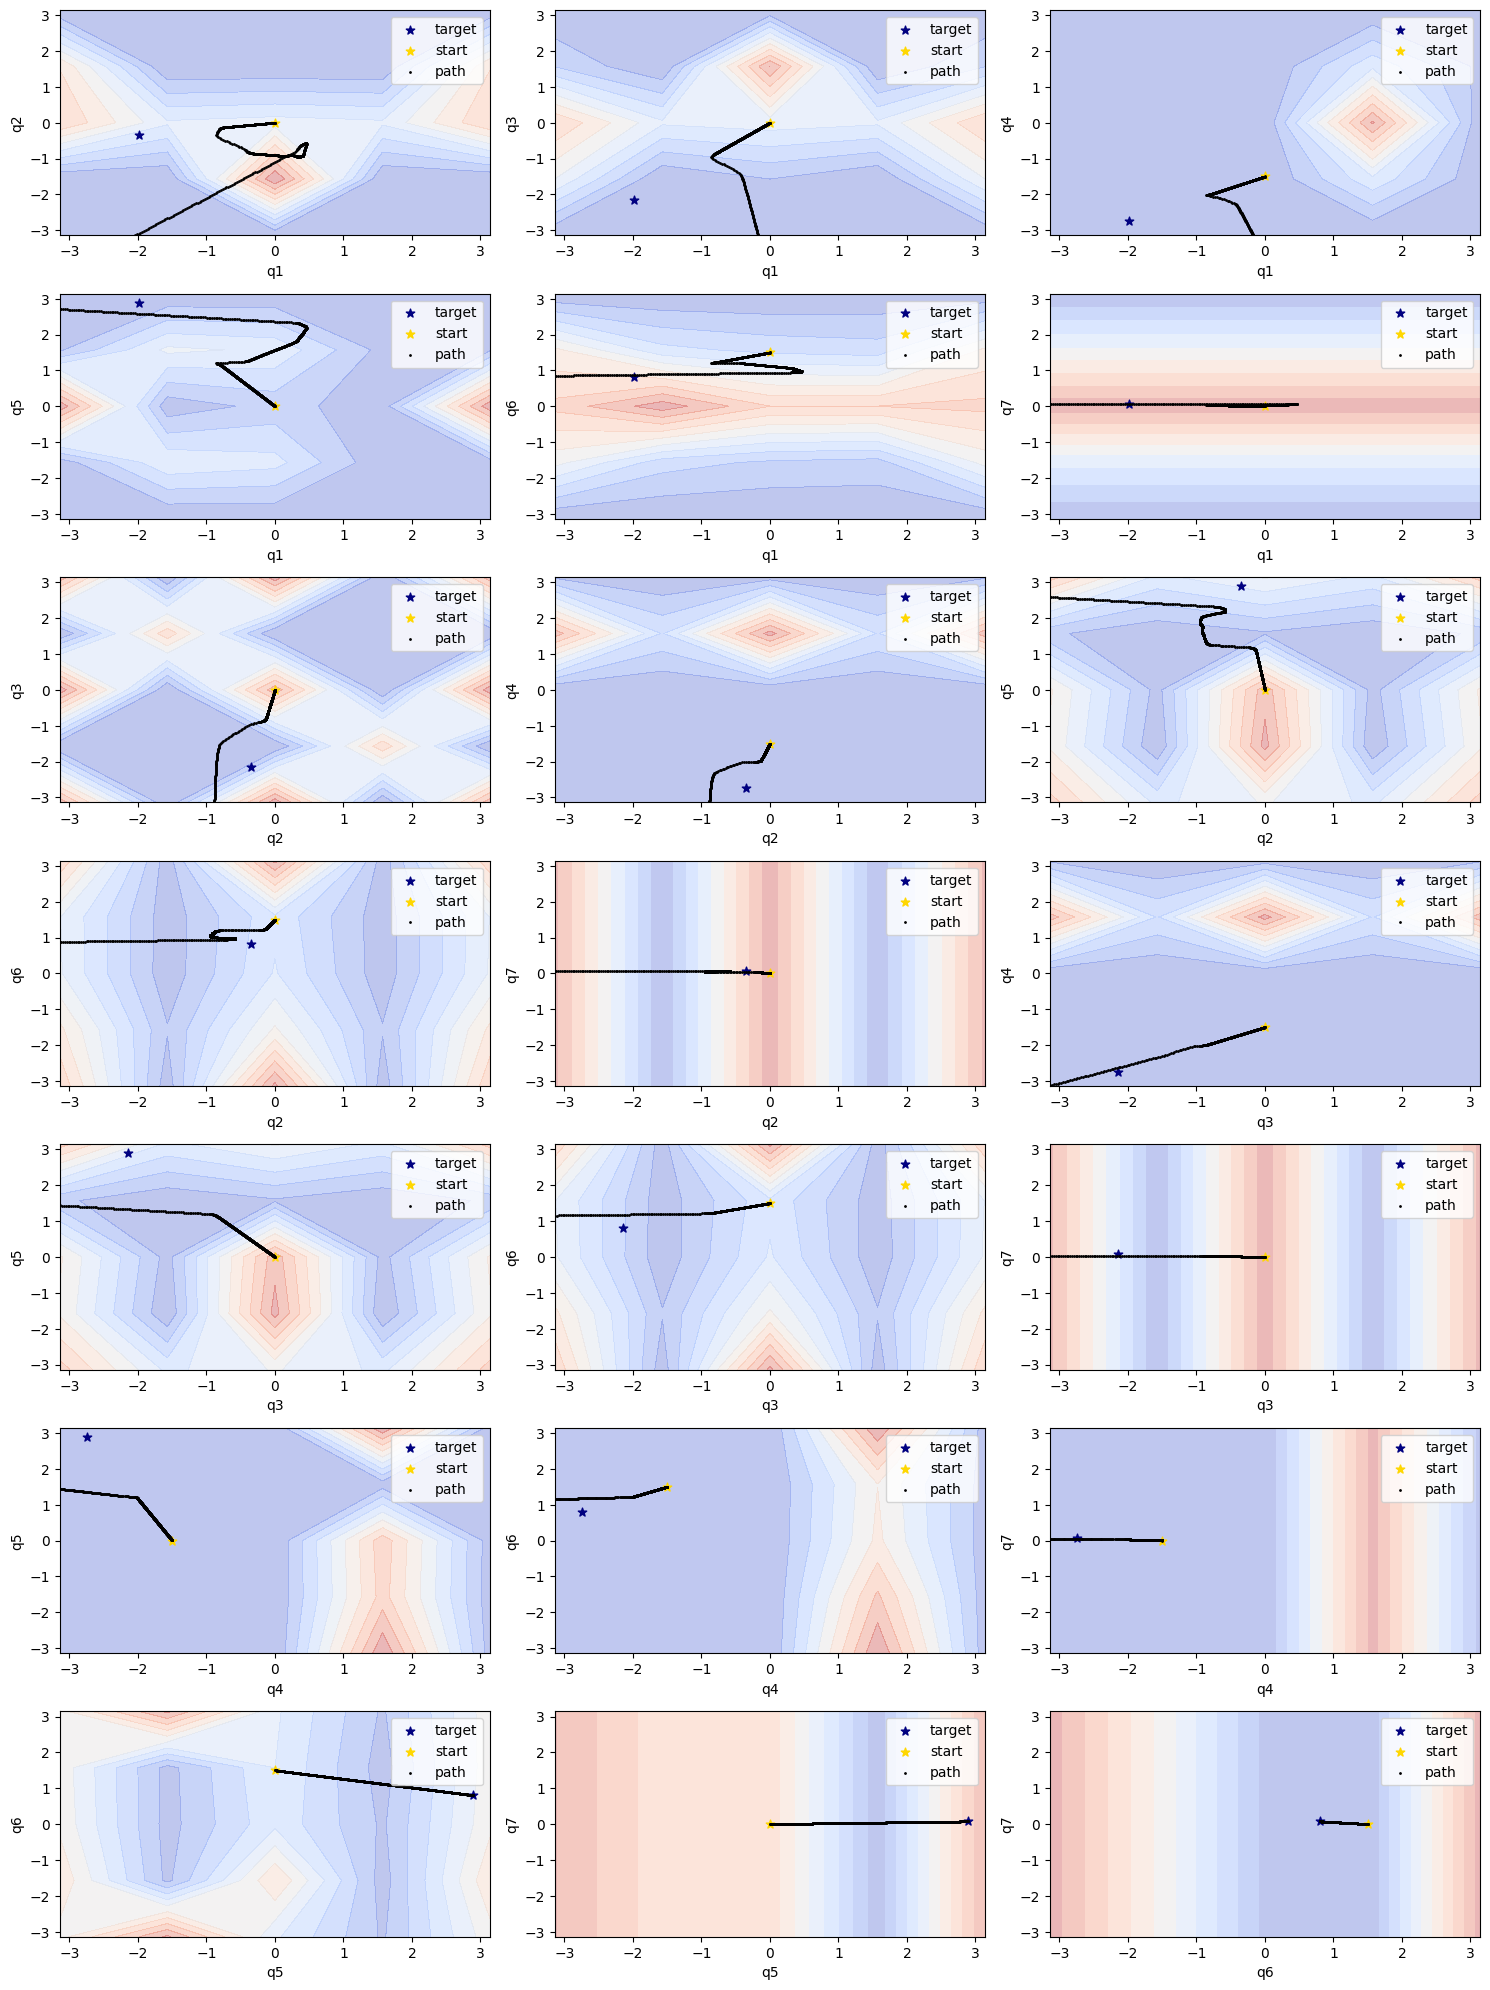

In [9]:
plot_coupled_embeddings(grid, config_attractor, embedding=a, streamlines=ps, start=config_start)
plt.show()

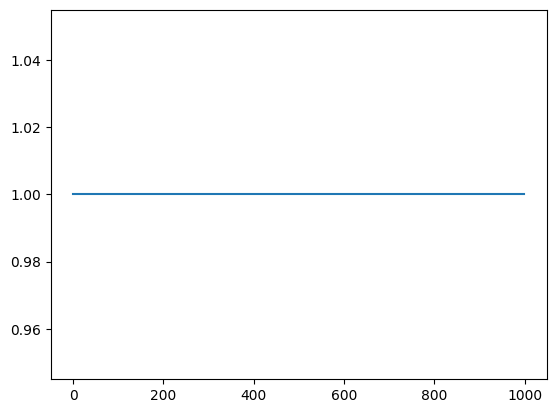

In [10]:
sigma = np.stack(ds.weight_logger)
plt.figure()
plt.plot(range(sigma.shape[0]), sigma)
plt.show()

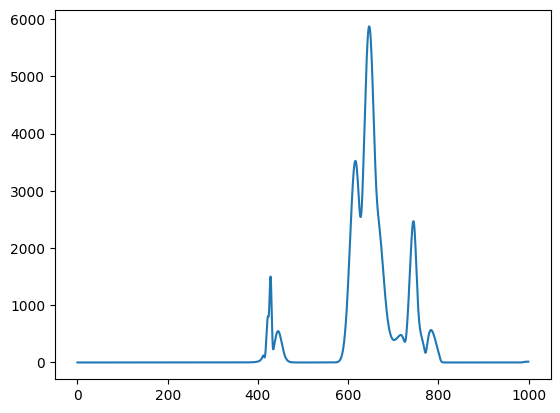

In [11]:
grad = np.stack(ds.gradient_logger)
plt.figure()
plt.plot(range(grad.shape[0]), np.linalg.norm(grad, axis=2))
plt.show()

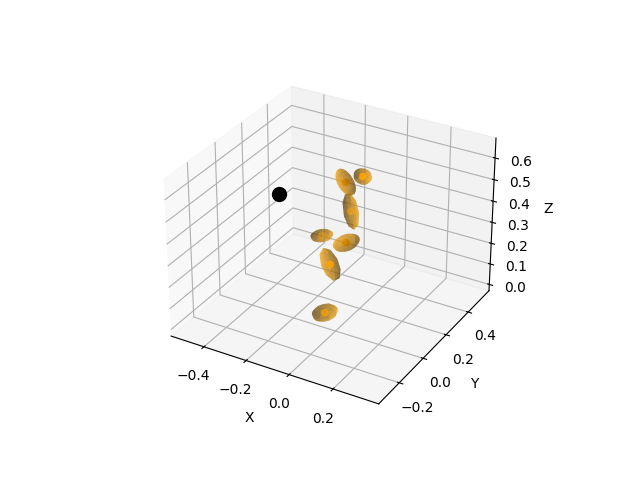

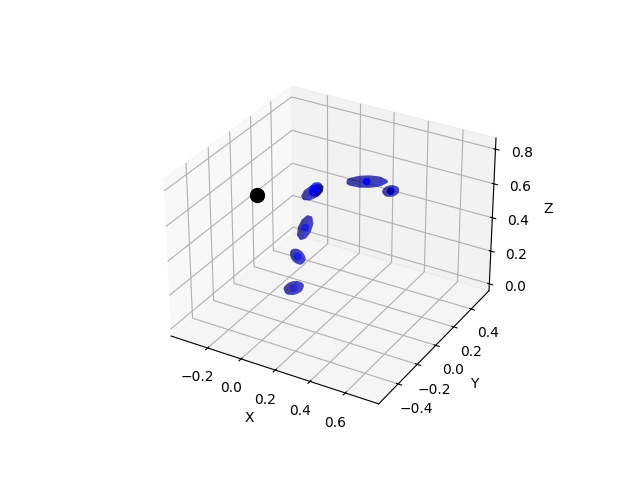

In [12]:
%matplotlib widget

# config_attractor = pin.randomConfiguration(fk.model, lower_bound, upper_bound)
speed = np.zeros_like(config_attractor)
fk(config_start, speed, derivation_order=0)
visualize_robot(fk=fk, obstacle=x, color='blue')
fk(config_attractor, speed, derivation_order=0)
visualize_robot(fk=fk, obstacle=x, color='orange')
plt.show()

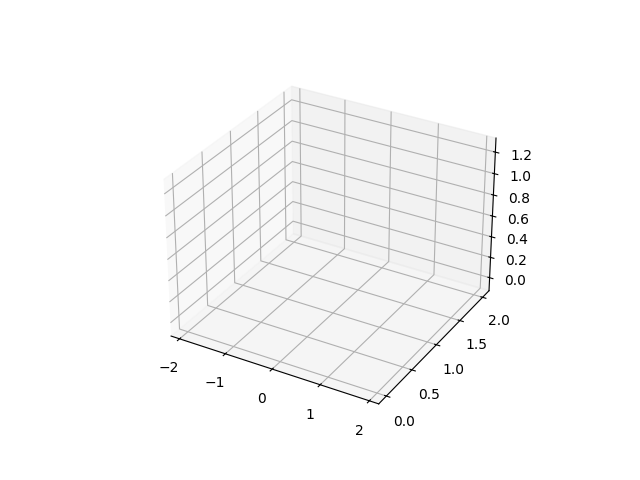

In [13]:
from matplotlib import animation

def animate_robot(i, configurations, fk: ForwardKinematic, obstacle, ax):
    ax.clear()
    ax.set_xlim([-2.1, 2.1])
    ax.set_ylim([-0.1, 2.1])
    ax.set_zlim([-0.1, 1.3])
    ax.scatter(obstacle[:, 0], obstacle[:, 1], obstacle[:, 2], c='black', s=100)
    q = configurations[i]
    pin.forwardKinematics(fk.model, fk.data, q)
    pin.updateFramePlacements(fk.model, fk.data)
    _ = fk(q=q, dq=np.zeros_like(q), derivation_order=0)
    ax.scatter(*(fk.mus[:, i] for i in range(3)))
    for i in range(fk.sigmas.shape[0]):
        plot_3d_ellipsoid_from_covariance(fk.sigmas[i], center=fk.mus[i], ax=ax)
    ax.set_xlim([-2.1, 2.1])
    ax.set_ylim([-0.1, 2.1])
    ax.set_zlim([-0.1, 1.3])
    ax.axis('equal')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlim([-2.1, 2.1])
ax.set_ylim([-0.1, 2.1])
ax.set_zlim([-0.1, 1.3])
dt = 0.004
step = int(np.round(0.016/dt))
ani = animation.FuncAnimation(fig, animate_robot, frames=np.arange(0, ps.shape[0], step, dtype=np.intc),fargs=(ps, fk, x, ax), interval=step*dt*1000, repeat=False)
# ani.save('vid.mp4')